In [178]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
ISMHW_PATH='F:/Pythons/ISM/ISMDataDir/'

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

class MyKernal:
    def __init__(self):
        pass
    def Gaussian(self,data,par):
        xdata,ydata=data
        if len(par)!=3:
            # print("Not enough initial parameters,start guessing:")
            a=np.max(ydata)
            x0=xdata[np.argmax(ydata)]
            sigma=np.sqrt(a)
            par=[a,x0,sigma]
            # print("using:x0=%s,sigma=%s,a=%s"%(x0,sigma,a))
            persistence=(a/sigma+.0001)
            if persistence<=1:
                # print("might not sounded")
                # pass
                return [-1,-1,-1]
        try:
            params, params_covariance = curve_fit(gaussian, xdata, ydata, p0=par)
        except:
            print("fitting cannot converge")
            return [-1,-1,-1]
        return params
    def Tex(self,Tpeak):
        return 5.532/np.log(1+5.532/(Tpeak+0.819))

def defualt(data):
    return []

class ISMHW:
    
    def __init__(self,fname,PATH):
        self.fname=fname
        self.PATH=PATH
        try:
            self.File=fits.open(PATH+fname)
        except:
            print("can not open file:%s"%PATH+fname)
            return -1

        self.AllData=self.File[0].data
        self.step3=self.File[0].header['CDELT3']
        self.offset3=self.File[0].header['CRVAL3']
        self.File.close()
        print("AllData shape:(%s,%s,%s)"%(self.AllData.shape[0],self.AllData.shape[1],self.AllData.shape[2]))

        
    def get_data(self,pixcelX,pixcelY):
        data=self.AllData[:,pixcelX,pixcelY]
        x=(np.arange(len(data))*self.step3+self.offset3)/1e3
        data=np.nan_to_num(data,nan=0.0)
        return [x,data]

    def fit_T_MB(self,kernal,pixcelX,pixcelY,parkernal=defualt,factor=0.5):
        # 计算TMB以及deltaV
        data=self.get_data(pixcelX,pixcelY)
        if np.max(data[1])<=0:
            # print("x=%s,y=%s has no data,skip this pixcel"%(pixcelX,pixcelY))
            return 0
        par1=parkernal(data)
        # print(data,par1)
        pars=kernal(data,par1)
        self.Tpeak,nothing,self.deltaV=pars
        if self.Tpeak<=0:
            return 0
        self.TMB=self.Tpeak*factor
        return 1
    
    def calculate_tau(self,phi,J,Tex,const1=5.29,const2=0.164):
        return -np.log(1-(self.TMB/phi)/(const1*(J(Tex)-const2)))

    def calculate_Cdensity(self,tau,Tex,const1=5.29):
        return 2.42e14*(tau*self.deltaV*Tex)/(1-np.exp(-const1/Tex))/1e16
    def main(self,ftype=J13,const1=5.29,const2=0.164,useDynamiclaTex=1):
        ls=[]
        for i in range(370):
            for j in range(297):
                tau,density,T=fun1(i,j,self,ftype=ftype,const1=const1,const2=const2,useDynamiclaTex=useDynamiclaTex)
                ls.append([tau,density,T])
        return ls

phi13=1
phi18=1

def J13(T):
    return 1/(np.exp(5.29/T)-1)
def J18(T):
    return 1/(np.exp(5.27/T)-1)
    # def

def fun1(x,y,ISMHW18,ftype=J13,const1=5.29,const2=0.164,useDynamiclaTex=1):
    KernalClass=MyKernal()
    flag=ISMHW18.fit_T_MB(KernalClass.Gaussian,x,y,factor=.5)
    if flag:
        if useDynamiclaTex!=1:
            tau=ISMHW18.calculate_tau(1,ftype,30,const1=const1,const2=const2)
            density=ISMHW18.calculate_Cdensity(tau,30,const1=const1)
            return tau,density,ISMHW18.TMB
        else:            
            tau=ISMHW18.calculate_tau(1,ftype,KernalClass.Tex(ISMHW18.Tpeak),const1=const1,const2=const2)
            density=ISMHW18.calculate_Cdensity(tau,KernalClass.Tex(ISMHW18.Tpeak),const1=const1)
            return tau,density,ISMHW18.TMB
        
    else:
        return -1,-1,-1

def MySort(data,x=370,y=297):
    tau=[]
    density=[]
    T=[]
    for i in data:
        tau.append(i[0])
        density.append(i[1])
        T.append(i[2])    
    tau=np.array(tau)
    density=np.array(density)
    T=np.array(T)    
    tau=tau.reshape(x,y)
    density=density.reshape(x,y)
    T=T.reshape(x,y)
    return density,tau,T
def Myplot(data,cbarlabel,name,norm='log'):
    plt.figure(figsize=(8,8))
    plt.imshow(data,norm=norm)
    cbar=plt.colorbar()
    cbar.set_label(label=cbarlabel,size=18)
    cbar.ax.tick_params(size=15)
    plt.xlabel("Y pixcel",fontsize=18)
    plt.ylabel("X pixcel",fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    plt.savefig(name+".jpg",dpi=400)

In [181]:
fname='channel_13co_tmb_base_cut.fits'

In [182]:
ISMHW18=ISMHW(fname,ISMHW_PATH)

AllData shape:(50,370,297)


In [183]:
ls=ISMHW18.main(useDynamiclaTex=0)

C:\Users\13599\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\13599\AppData\Local\Temp\ipykernel_8104\3888539183.py:80: RuntimeWarning: invalid value encountered in log
  return -np.log(1-(self.TMB/phi)/(const1*(J(Tex)-const2)))


fitting cannot converge
fitting cannot converge
fitting cannot converge


C:\Users\13599\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:488: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge
fitting cannot converge


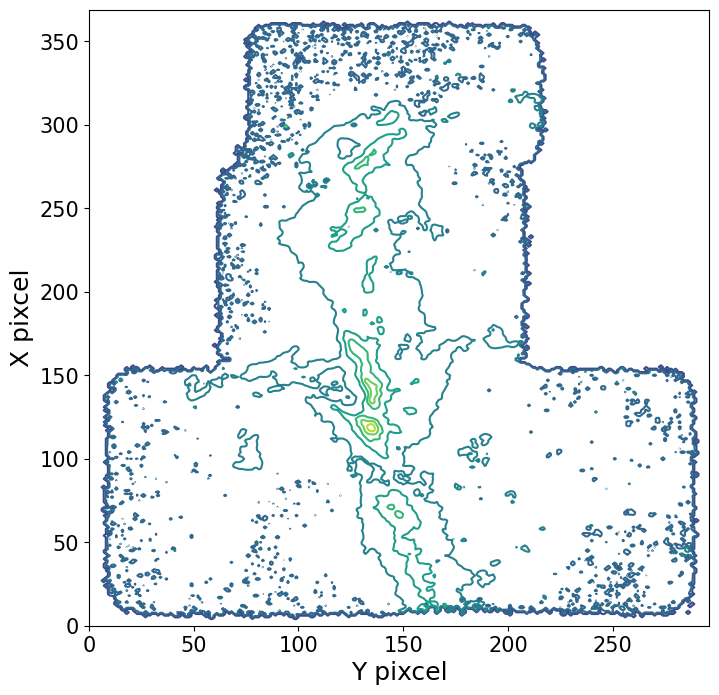

In [190]:
plt.figure(figsize=(8,8))
plt.contour(a)
# cbar.set_label(label=cbarlabel,size=18)
# cbar.ax.tick_params(size=15)
plt.xlabel("Y pixcel",fontsize=18)
plt.ylabel("X pixcel",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.savefig('densityCT'+".jpg",dpi=400)


In [184]:
a,b,c=MySort(ls)

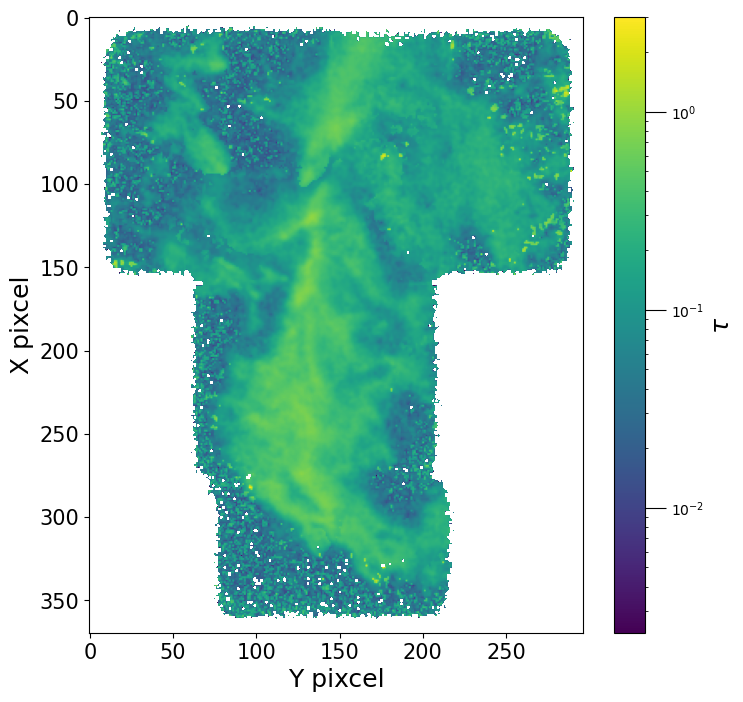

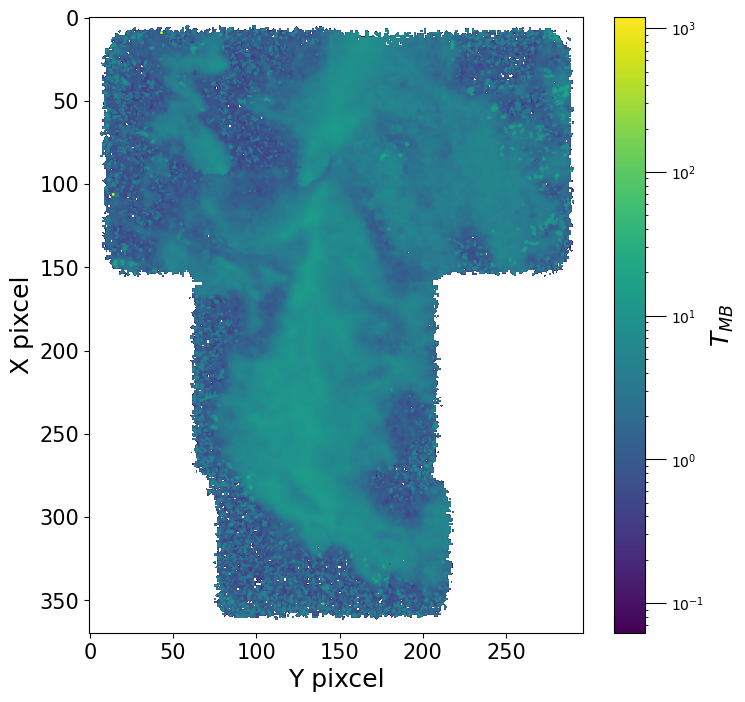

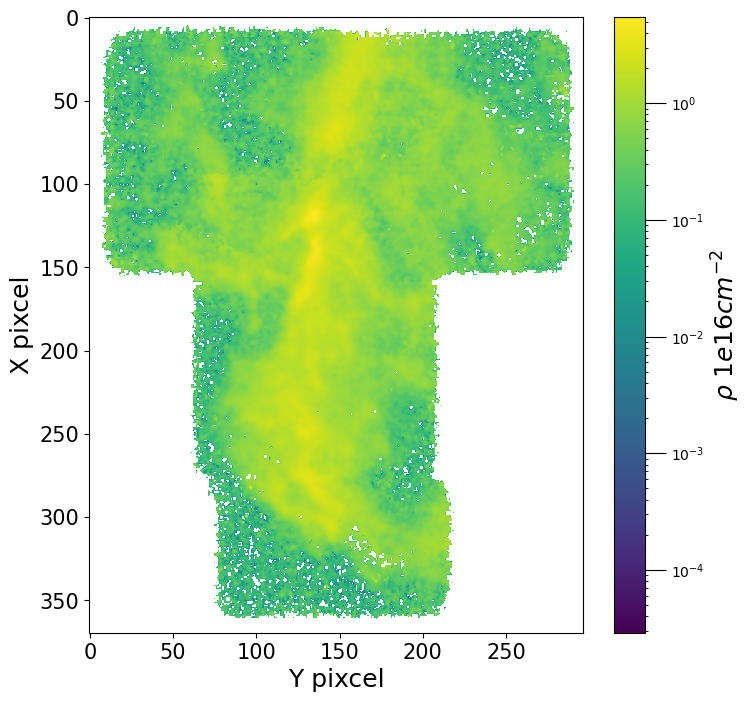

In [185]:
Myplot(b,r"$\tau$","Tau",norm='log')
Myplot(c,r"$T_{MB}$","T")
Myplot(a,r"$\rho\ 1e16cm^{-2}$","density")

In [160]:
fname='channel_c18o_tmb_base_cut.fits'

In [161]:
ISMHW18=ISMHW(fname,ISMHW_PATH)

AllData shape:(50,370,297)


In [162]:
ls=ISMHW18.main(ftype=J18,const1=5.27,const2=0.1666)

C:\Users\13599\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


fitting cannot converge


C:\Users\13599\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:488: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


fitting cannot converge
fitting cannot converge
fitting cannot converge


In [163]:
a,b,c=MySort(ls)

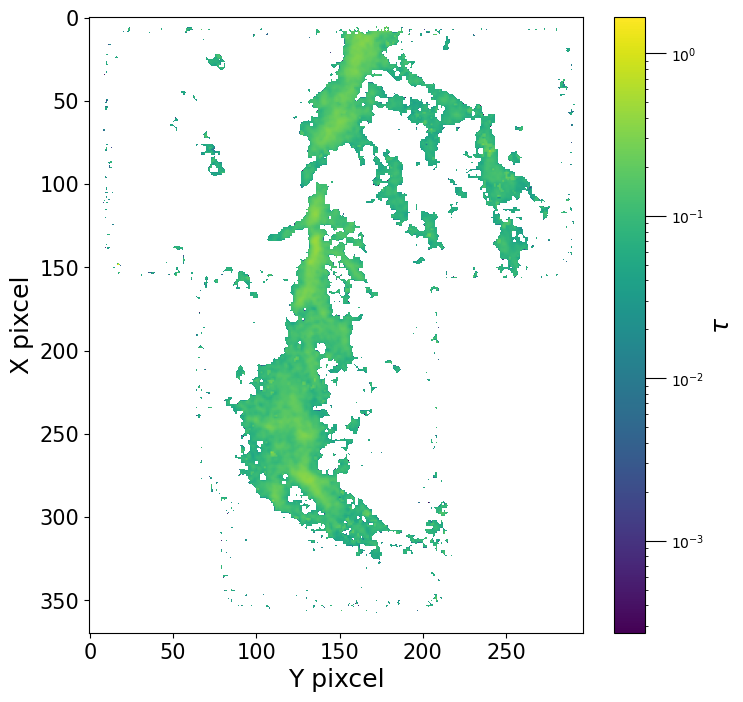

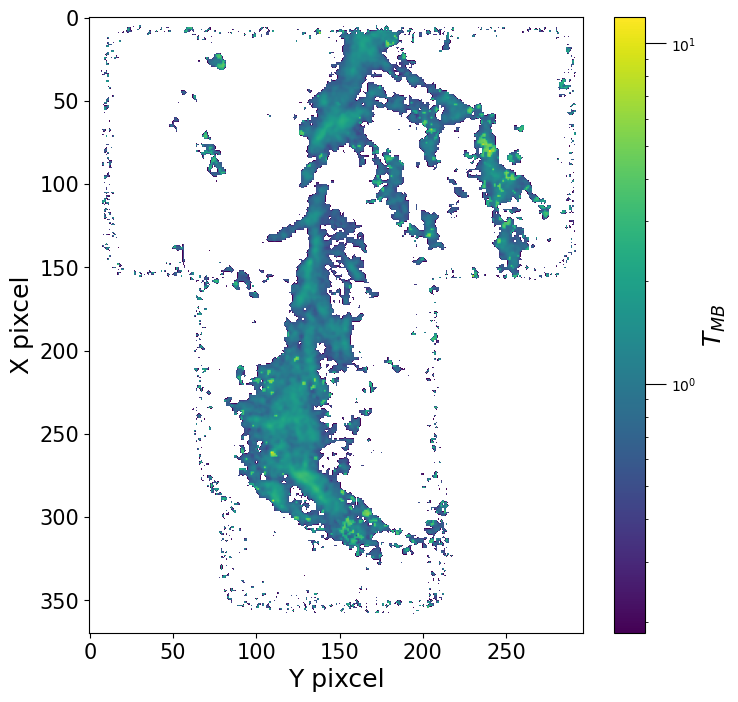

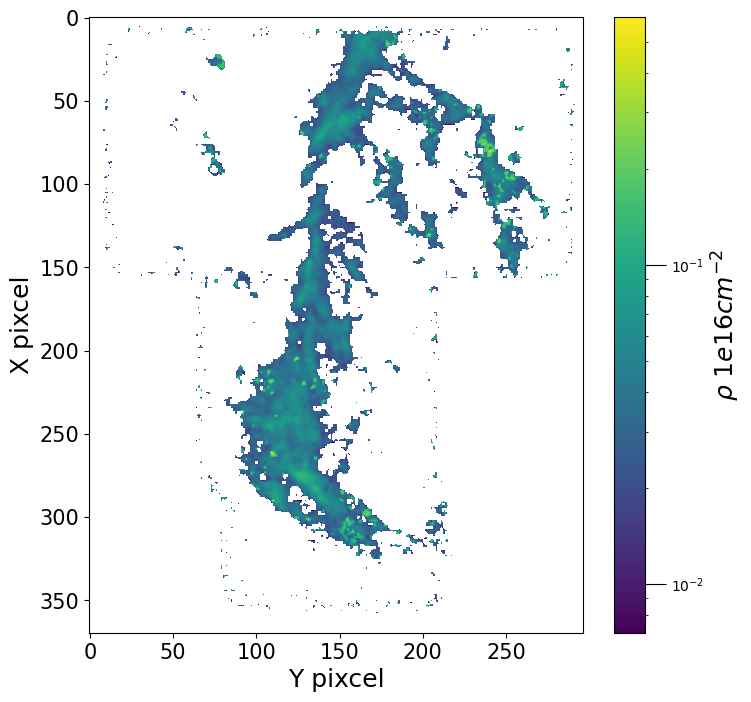

In [164]:
Myplot(a,r"$\tau$","Tau18")
Myplot(c,r"$T_{MB}$","T18")
Myplot(b,r"$\rho\ 1e16cm^{-2}$","density18")